In [1]:
# install pytorch 
# conda install -c pytorch pytorch
# pip3 install torch==1.9.1+cu102 torchvision==0.10.1+cu102 torchaudio===0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
import torch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

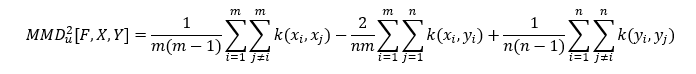

In [4]:
## the code is a combination between:
## - this forum answer: https://discuss.pytorch.org/t/maximum-mean-discrepancy-mmd-and-radial-basis-function-rbf/1875/2
## - this tutorial: https://www.kaggle.com/onurtunali/maximum-mean-discrepancy

def MMD(x, y, kernel, kernel_bandwidth):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    
    ## torch.mm performs matrix multiplication
    ## x.t() performs a transpose
    ## xx.diag() contains the square of each row/point in x
    xx, yy, xy = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    
    ## calculating the first summation of parts A and C
    # unsqueze adds another dimension to the tensor (,n) to (1,n)
    # expand_as duplicates the array to as many rows to match the array given 
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    # compute the distance matrix: (x - y)^2 = x^2 - 2*x*y + y^2
    dxx = rx.t() - 2 * xx + rx 
    dyy = ry.t() - 2 * yy + ry 
    dxy = rx.t() - 2 * xy + ry 
    
    if kernel == "multiscale":
        XX = kernel_bandwidth**2 * (kernel_bandwidth**2 + dxx)**-1
        YY = kernel_bandwidth**2 * (kernel_bandwidth**2 + dyy)**-1
        XY = kernel_bandwidth**2 * (kernel_bandwidth**2 + dxy)**-1
            
    if kernel == "rbf":
        XX = torch.exp(-0.5*dxx/kernel_bandwidth)
        YY = torch.exp(-0.5*dyy/kernel_bandwidth)
        XY = torch.exp(-0.5*dxy/kernel_bandwidth)
    
    if kernel == "linear":
        XX = kernel_bandwidth * xx
        YY = kernel_bandwidth * yy
        XY = kernel_bandwidth * xy

    m = x.size()[0]
    n = y.size()[0]
    
    return 1/(m*(m-1)) * torch.sum(XX) - 2/(m*n) * torch.sum(XY) + 1/(n*(n-1)) * torch.sum(YY)

In [5]:
## The data used are publicly available at:
### - https://archive.ics.uci.edu/ml/datasets/GNFUV+Unmanned+Surface+Vehicles+Sensor+Data+Set+2 (experiment 1 & 2)
### - https://archive.ics.uci.edu/ml/datasets/GNFUV+Unmanned+Surface+Vehicles+Sensor+Data (experiment 3)

## Did some refactoring to the original data folders but you can change the code according to your system.
## Also I renamed the files of experiment 3 to follow the same convention as experiments 1 & 2

import pandas as pd
from csv import reader
import ast
from datetime import datetime as dt
import os

# os.chdir("..")

## Each experiment has four nodes, pi2, pi3, pi4 and pi5
nodes = ["pi" + str(i) for i in range(2,6)]
## and the following attributes are recorded by the each nodes device:
### - humidity
### - temperature
### - time of the recording

## therefore each data row should record the following
attributes = ["device", "humidity", "temperature", "time", "pi", "experiment"]

def read_data():
    experiments_data = []
    for i in range(1,4):
        experiment =  "experiment_" + str(i)
        directory = "//".join([os.getcwd(), "data", experiment])
        experiment_files = os.listdir(directory)
        data = []
        for file in experiment_files:
            name = file.split(".")[0]
            if name in nodes:
                node_directory = directory + "//" + file
                if ".csv" in file:
                    with open(node_directory, 'r') as f:
                        file_data = []
                        # pass the file object to reader() to get the reader object
                        csv_reader = reader(f)
                        # Iterate over each row in the csv using reader object
                        for row in csv_reader:
                            dictionary = ast.literal_eval(",".join(row))
                            file_data.append(dictionary)
                        ## create a dataframe from the rows of dictionaries and drop rows with NaN values
                        node_data = pd.DataFrame(file_data).dropna()
                        node_data["pi"] = name
                        node_data.time = [dt.fromtimestamp(epoch_time).strftime("%d-%m-%Y, %H:%M:%S.%f") \
                                          for epoch_time in node_data.time.values]
                        node_data.humidity = node_data.humidity.astype(int)
                        node_data.temperature = node_data.temperature.astype(int)

                elif ".xlsx" in file:
                    node_data = pd.read_excel(node_directory).dropna()
                    node_data.columns= node_data.columns.str.lower()
                    node_data = node_data.loc[~(node_data.humidity == " None")]
                    node_data = node_data.loc[~(node_data.temperature == " None")]
                    node_data.device = node_data.device.str.replace("\'", "")
                node_data.pi = node_data.pi.str.lower()
                node_data.experiment = i
                data.append(node_data)

        experiments_data.append(pd.concat(data).reset_index(drop=True))
    return pd.concat(experiments_data).reset_index(drop=True)

In [6]:
data = read_data()

In [7]:
def get_node_data(exp):
    a = exp.loc[data.pi=="pi2"]
    b = exp.loc[data.pi=="pi3"]
    c = exp.loc[data.pi=="pi4"]
    d = exp.loc[data.pi =="pi5"]
    return a,b,c,d

In [16]:
import matplotlib.pyplot as plt

def plot_experiment(a,b,c,d):
    plt.rcParams["figure.figsize"] = (8,5)
    
    plt.scatter(a.humidity, a.temperature, marker= ".", label="pi2", alpha =0.5)
    plt.scatter(b.humidity, b.temperature, marker = "v", label="pi3", alpha=0.5)
    plt.scatter(c.humidity, c.temperature, marker = "^", label="pi4", alpha=0.5)
    plt.scatter(d.humidity, d.temperature, marker = "*", label="pi5", alpha=0.5)
    plt.legend()
    plt.xlabel(xlabel="Humidity")
    plt.ylabel(ylabel="Temperature")
    plt.show()

def plot_experiments():
    for i in range(1,4):
        exp = data.loc[data.experiment==i][["humidity", "temperature"]]
        a,b,c,d = get_node_data(exp)
        plot_experiment(a,b,c,d)

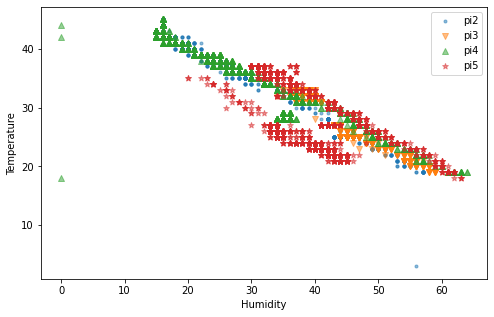

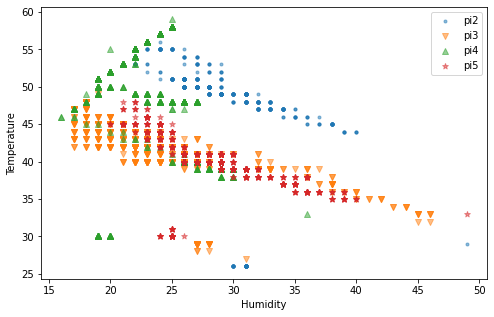

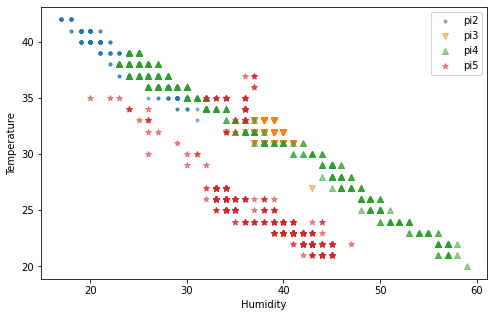

In [17]:
plot_experiments()

In [13]:
import numpy as np

def get_tensor_sample(data, sample_size):
    return torch.tensor(data.sample(sample_size).values.astype(np.float32)).to(device)

def get_tensor_samples(experiment, sample_size):
    exp = data.loc[data.experiment==experiment][["humidity", "temperature"]]
    a,b,c,d  = get_node_data(exp)
    sa = get_tensor_sample(a,sample_size)
    sb = get_tensor_sample(b,sample_size)
    sc = get_tensor_sample(c,sample_size)
    sd = get_tensor_sample(d.loc[~((d.humidity>30) & (d.temperature>30))], sample_size)
    
    return sa, sb, sc, sd

sa, sb, sc, sd = get_tensor_samples(experiment=3, sample_size=50)

In [14]:
from itertools import combinations as comb
def calculate_MMD(x,y,kernel, kernel_bandwidth):
    return MMD(x,y, kernel, kernel_bandwidth)
    
def print_MMD(x,y, kernel, kernel_bandwidth):  
    result = MMD(x,y, kernel, kernel_bandwidth)
    print(f"MMD result of X and Y is {result.item()}")

def calculate_avg_similarity_disimilarity_MMD(similar_sets, dissimilar_set, kernel, kernel_bandwidth):
    combos = comb(range(len(similar_sets)),2)
    similar_mmds = []
    for combo in combos:
        x = similar_sets[combo[0]]
        y = similar_sets[combo[1]]
        mmd = MMD(x,y, kernel, kernel_bandwidth)
        similar_mmds.append(mmd)
    
    x = dissimilar_set
    dissimilar_mmds = []
    for i in range(len(similar_sets)):
        y = similar_sets[i]
        mmd = MMD(x,y, kernel, kernel_bandwidth)
        dissimilar_mmds.append(mmd)
    
    print("Similarity MMD: ", np.mean(similar_mmds))
    print("Dissimilarity MMD: ", np.mean(dissimilar_mmds))

def bandwidth_experiment(bandwidths, kernel):
    print(kernel)
    for bandwidth in bandwidths:
        print(bandwidth)
        calculate_avg_similarity_disimilarity_MMD([sa,sb,sc],sd, kernel, bandwidth)
        print()

In [15]:
bandwidth_experiment(np.linspace(0.05, 0.8, 4), "linear")

linear
0.05
Similarity MMD:  13.399887
Dissimilarity MMD:  13.621907

0.3
Similarity MMD:  80.399376
Dissimilarity MMD:  81.731445

0.55
Similarity MMD:  147.39851
Dissimilarity MMD:  149.84077

0.8
Similarity MMD:  214.3982
Dissimilarity MMD:  217.95052



In [16]:
bandwidth_experiment(np.linspace(5, 50, 6), "rbf")

rbf
5.0
Similarity MMD:  0.70515007
Dissimilarity MMD:  0.72949433

14.0
Similarity MMD:  0.826948
Dissimilarity MMD:  0.9199082

23.0
Similarity MMD:  0.847408
Dissimilarity MMD:  0.9439771

32.0
Similarity MMD:  0.843772
Dissimilarity MMD:  0.932498

41.0
Similarity MMD:  0.8301625
Dissimilarity MMD:  0.9106303

50.0
Similarity MMD:  0.8117242
Dissimilarity MMD:  0.88543624

